Now that you have a trained network, you can use it for making predictions. This is typically called inference, a term borrowed from statistics. However, neural networks have a tendency to perform too well on the training data and aren't able to generalize to data that hasn't been seen before. This is called overfitting and it impairs inference performance. To test for overfitting while training, we measure the performance on data not in the training set called the validation set. We avoid overfitting through regularization such as dropout while monitoring the validation performance during training. In this notebook, I'll show you how to do this in PyTorch.



In [123]:
import torch
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [124]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784,256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128,64)
        self.fc4 = nn.Linear(64,10)
        
    def forward(self,x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x
        

In [125]:
model = Classifier()

In [126]:
images, labels = next(iter(testloader))
# Get the class probabilities
ps = torch.exp(model(images))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


With the probabilities, we can get the most likely class using the <code>ps.topk</code> method. This returns the  highest values. Since we just want the most likely class, we can use <code>ps.topk(1)</code>. This returns a tuple of the top- values and the top- indices. If the highest value is the fifth element, we'll get back 4 as the index.

In [127]:
top_p, top_class = ps.topk(1,dim=1)
# Look at the most likely classes for the first 10 examples
print(top_class.shape)

torch.Size([64, 1])


In [128]:
top_p

tensor([[0.1105],
        [0.1101],
        [0.1101],
        [0.1097],
        [0.1115],
        [0.1104],
        [0.1111],
        [0.1101],
        [0.1078],
        [0.1123],
        [0.1098],
        [0.1108],
        [0.1113],
        [0.1098],
        [0.1074],
        [0.1098],
        [0.1119],
        [0.1098],
        [0.1100],
        [0.1091],
        [0.1102],
        [0.1104],
        [0.1098],
        [0.1103],
        [0.1107],
        [0.1109],
        [0.1117],
        [0.1099],
        [0.1116],
        [0.1100],
        [0.1108],
        [0.1120],
        [0.1095],
        [0.1098],
        [0.1089],
        [0.1088],
        [0.1093],
        [0.1105],
        [0.1086],
        [0.1107],
        [0.1116],
        [0.1098],
        [0.1089],
        [0.1113],
        [0.1100],
        [0.1101],
        [0.1124],
        [0.1094],
        [0.1112],
        [0.1089],
        [0.1089],
        [0.1102],
        [0.1084],
        [0.1124],
        [0.1076],
        [0

In [129]:
top_class.shape

torch.Size([64, 1])

In [130]:
labels.shape

torch.Size([64])

In [131]:
equals = top_class == labels

In [132]:
equals

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

In [133]:
equals.shape

torch.Size([64, 64])

In [134]:
top_class[:10]

tensor([[2],
        [8],
        [2],
        [2],
        [9],
        [9],
        [8],
        [2],
        [9],
        [3]])

In [135]:
labels[:10]

tensor([9, 7, 6, 6, 3, 3, 1, 7, 3, 3])

In [136]:
equals = top_class == labels.view(*top_class.shape)

In [137]:
equals

tensor([[False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [ True],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False

In [138]:
top_class.shape

torch.Size([64, 1])

In [139]:
labels.shape

torch.Size([64])

In [149]:
accuracy = torch.mean(equals.to(torch.half))
print(f'accuracy : {accuracy}' )
print(f'Accuracy: {accuracy.item()*100}%')

accuracy : 0.75
Accuracy: 75.0%


In [141]:
model = Classifier()
criterion = nn.NLLLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 10

train_losses, test_losses = [],[]
for e in range(epochs):
    tot_train_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        tot_train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    else:
        tot_test_loss = 0
        test_correct = 0  # Number of correct predictions on the test set
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                loss = criterion(log_ps, labels)
                tot_test_loss += loss.item()

                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                test_correct += equals.sum().item()

        # Get mean loss to enable comparison between train and test sets
        train_loss = tot_train_loss / len(trainloader.dataset)
        test_loss = tot_test_loss / len(testloader.dataset)

        # At completion of epoch
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_loss),
              "Test Loss: {:.3f}.. ".format(test_loss),
              "Test Accuracy: {:.3f}".format(test_correct / len(testloader.dataset)))

Epoch: 1/10..  Training Loss: 0.510..  Test Loss: 0.488..  Test Accuracy: 0.830
Epoch: 2/10..  Training Loss: 0.389..  Test Loss: 0.404..  Test Accuracy: 0.856
Epoch: 3/10..  Training Loss: 0.356..  Test Loss: 0.395..  Test Accuracy: 0.856
Epoch: 4/10..  Training Loss: 0.335..  Test Loss: 0.387..  Test Accuracy: 0.861
Epoch: 5/10..  Training Loss: 0.318..  Test Loss: 0.412..  Test Accuracy: 0.858
Epoch: 6/10..  Training Loss: 0.307..  Test Loss: 0.372..  Test Accuracy: 0.869
Epoch: 7/10..  Training Loss: 0.292..  Test Loss: 0.367..  Test Accuracy: 0.875
Epoch: 8/10..  Training Loss: 0.280..  Test Loss: 0.359..  Test Accuracy: 0.876
Epoch: 9/10..  Training Loss: 0.273..  Test Loss: 0.384..  Test Accuracy: 0.871
Epoch: 10/10..  Training Loss: 0.269..  Test Loss: 0.369..  Test Accuracy: 0.874


In [142]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

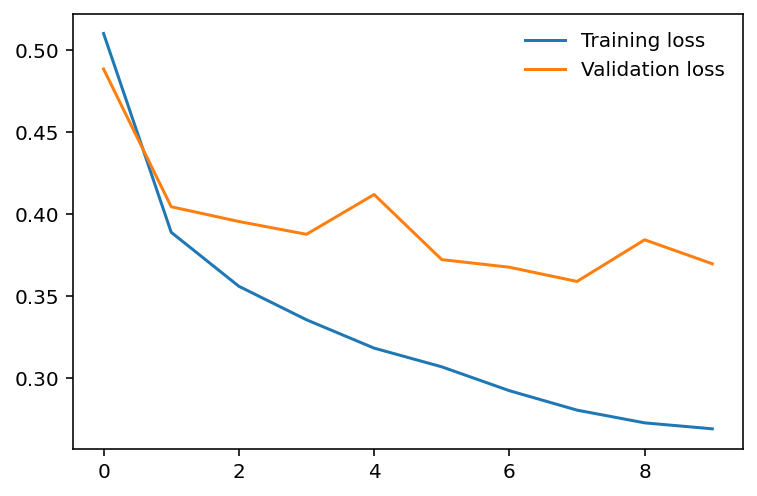

In [143]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Overfitting

If we look at the training and validation losses as we train the network, we can see a phenomenon known as overfitting.

The network learns the training set better and better, resulting in lower training losses. However, it starts having problems generalizing to data outside the training set leading to the validation loss increasing. The ultimate goal of any deep learning model is to make predictions on new data, so we should strive to get the lowest validation loss possible. One option is to use the version of the model with the lowest validation loss, here the one around 8-10 training epochs. This strategy is called <b>early-stopping</b>. In practice, you'd save the model frequently as you're training then later choose the model with the lowest validation loss.

The most common method to reduce overfitting (outside of early-stopping) is <b>dropout</b>, where we randomly drop input units. This forces the network to share information between weights, increasing it's ability to generalize to new data. Adding dropout in PyTorch is straightforward using the <code>nn.Dropout</code> module.

In [144]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

During training we want to use `dropout` to prevent overfitting, but during inference we want to use the entire network. So,<b> we need to turn off dropout during validation, testing, and whenever we're using the network to make predictions</b>. To do this, you use <code>model.eval()</code>. This sets the model to evaluation mode where the dropout probability is 0. You can <b>turn dropout back on by setting the model to train mode with <code>model.train()</code>.</b> In general, the pattern for the validation loop will look like this, where you turn off gradients, set the model to evaluation mode, calculate the validation loss and metric, then set the model back to train mode.

'''
    
    with torch.no_grad():

        # set model to evaluation mode
        model.eval()

        # validation pass here
        for images, labels in testloader:
            ...
    # set model back to train mode
    model.train()
'''

In [145]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 10
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/10..  Training Loss: 0.606..  Test Loss: 0.473..  Test Accuracy: 0.826
Epoch: 2/10..  Training Loss: 0.485..  Test Loss: 0.443..  Test Accuracy: 0.838
Epoch: 3/10..  Training Loss: 0.445..  Test Loss: 0.441..  Test Accuracy: 0.844
Epoch: 4/10..  Training Loss: 0.433..  Test Loss: 0.409..  Test Accuracy: 0.857
Epoch: 5/10..  Training Loss: 0.421..  Test Loss: 0.399..  Test Accuracy: 0.862
Epoch: 6/10..  Training Loss: 0.411..  Test Loss: 0.388..  Test Accuracy: 0.861
Epoch: 7/10..  Training Loss: 0.401..  Test Loss: 0.422..  Test Accuracy: 0.847
Epoch: 8/10..  Training Loss: 0.395..  Test Loss: 0.393..  Test Accuracy: 0.860
Epoch: 9/10..  Training Loss: 0.389..  Test Loss: 0.398..  Test Accuracy: 0.855
Epoch: 10/10..  Training Loss: 0.388..  Test Loss: 0.384..  Test Accuracy: 0.869


In [146]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

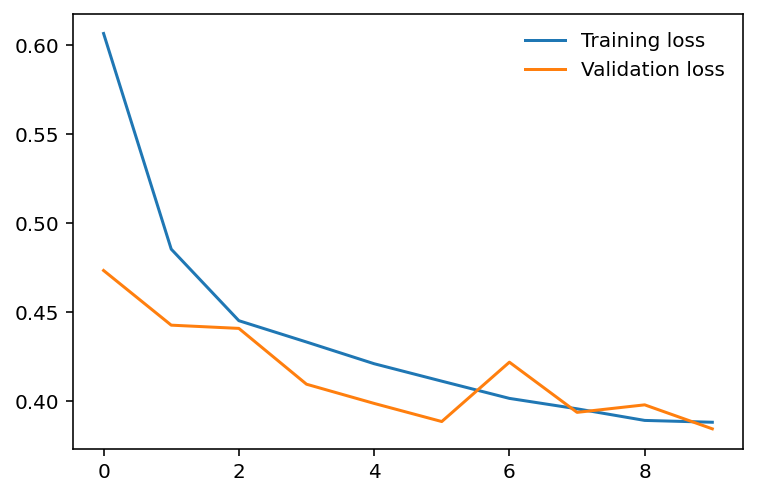

In [147]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Inference

Now that the model is trained, we can use it for inference. We've done this before, but now we need to remember to set the model in inference mode with <code>model.eval()</code>. You'll also want to turn off autograd with the <code>torch.no_grad()</code> context.

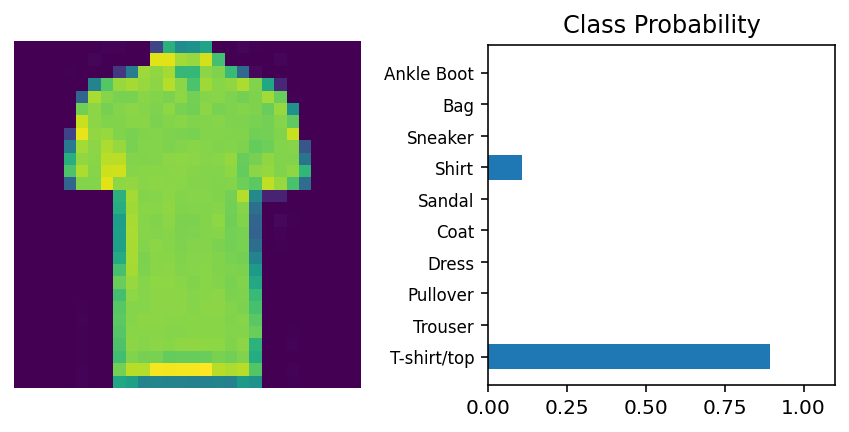

In [148]:
# Import helper module (should be in the repo)
import helper

# Test out your network!

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')